In [1]:
%matplotlib inline

import xarray as xa
import netCDF4 as nc
import pandas as pd
import numpy as np
import urllib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

/Users/bell/anaconda/envs/jupyter/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


The following cell loads the dataset from an ERDDAP server.  It can be accessed like a opendap/thredds server for netcdf, but sends the data in a **streaming** format which is hard to figure out how to parse.  So instead, download a temporary file specifying the parameters in the url. 

Alternatives would be to access streaming version of csv file or other filetype from ERDDAP Server and process via pandas

In [2]:
ALAMOID = "http://ferret.pmel.noaa.gov/alamo/erddap/tabledap/arctic_heat_alamo_profiles_9119"
cmap = cmocean.cm.thermal
temp_filename = "data/tmp.nc"

start_date="2017-09-13"
urllib.urlretrieve(ALAMOID+".ncCFMA?profileid%2CFLOAT_SERIAL_NO%2CCYCLE_NUMBER%2CREFERENCE_DATE_TIME%2CJULD%2Ctime%2Clatitude%2Clongitude%2CPRES%2CTEMP%2CPSAL&time%3E="+start_date+"T23%3A52%3A00Z",temp_filename)


('data/tmp.nc', <httplib.HTTPMessage instance at 0x10c933908>)

In [3]:
#datanc = nc.Dataset('data/tmp.nc') #using netcdf library
dataxa = xa.open_dataset('data/tmp.nc')

print dataxa

<xarray.Dataset>
Dimensions:              (obs: 87, profile: 97)
Coordinates:
    time                 (profile, obs) datetime64[ns] 2017-09-13T23:52:00 ...
    latitude             (profile, obs) float64 70.01 70.01 70.01 70.01 ...
    longitude            (profile, obs) float64 -166.9 -166.9 -166.9 -166.9 ...
    PRES                 (profile, obs) float64 25.32 24.52 23.48 22.44 ...
Dimensions without coordinates: obs, profile
Data variables:
    profileid            (profile) |S10 u'R9119_0000R9119_0001' ...
    FLOAT_SERIAL_NO      (profile, obs) |S4 u'911991199119911991' ...
    CYCLE_NUMBER         (profile, obs) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    REFERENCE_DATE_TIME  (profile, obs) |S14 u'195001010000001950' ...
    JULD                 (profile, obs) datetime64[ns] 2017-09-13T22:37:54 ...
    TEMP                 (profile, obs) float64 7.296 7.277 7.267 7.266 ...
    PSAL                 (profile, obs) float64 31.05 31.04 31.04 31.03 ...
Attributes:
    cdm_altitude_p

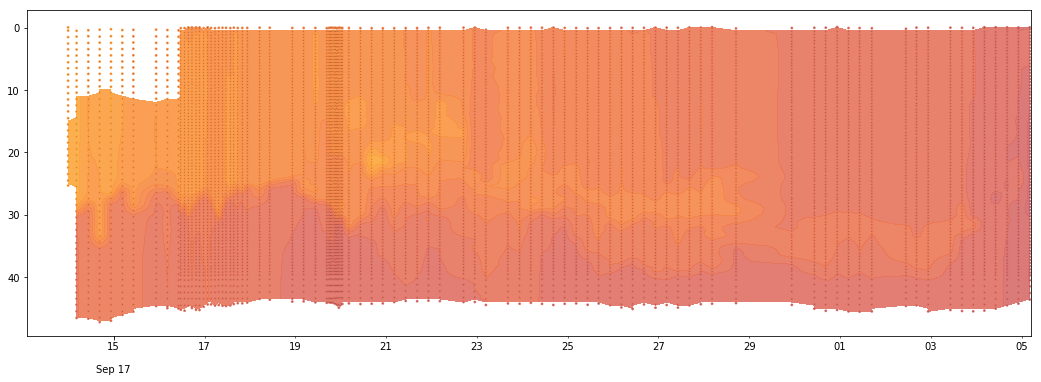

In [4]:
depth_array = np.arange(0,50,0.5)
temparray = np.ones((dataxa.dims['profile'],len(depth_array)))*np.nan
ProfileTime = []
cycle_col = 0

plt.figure(1, figsize=(18, 6), facecolor='w', edgecolor='w')
plt.subplot(1,1,1)
ax1=plt.gca()

for cycle in range(dataxa['profile'].min(),dataxa['profile'].max()+1,1):
    temp_time =  dataxa.time[cycle].data
    ProfileTime = ProfileTime + [temp_time]
    Pressure = dataxa.PRES[cycle].data
    Temperature = dataxa.TEMP[cycle].data
    #Temperature[Temperature<30.] = np.nan

    temparray[cycle_col,:] = np.interp(depth_array,np.flip(Pressure,axis=0),np.flip(Temperature,axis=0),left=np.nan,right=np.nan)
    cycle_col +=1

    plt.scatter(x=temp_time, y=Pressure,s=1,marker='.', edgecolors='none', c='k', zorder=3, alpha=1)
    plt.scatter(x=temp_time, y=Pressure,s=30,marker='.', edgecolors='none', c=Temperature, 
      vmin=-2, vmax=10, cmap=cmocean.cm.thermal, zorder=1)

time_array = np.array([x[0] for x in ProfileTime])
plt.contourf(time_array,depth_array,temparray.T, 
    extend='both', cmap=cmocean.cm.thermal, 
    levels=np.arange(-2,10,0.25), alpha=0.9)
  
    
ax1.invert_yaxis()
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(bymonthday=range(1,33,2)))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=25)

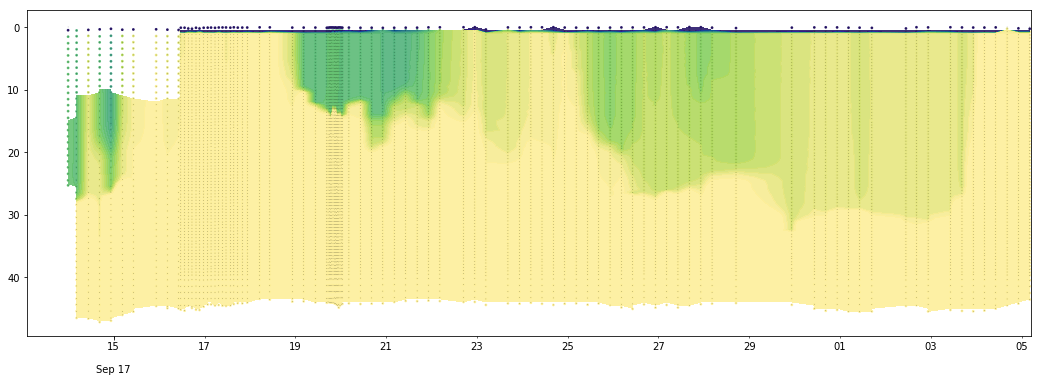

In [5]:
depth_array = np.arange(0,50,0.5)
temparray = np.ones((dataxa.dims['profile'],len(depth_array)))*np.nan
ProfileTime = []
cycle_col = 0

plt.figure(1, figsize=(18, 6), facecolor='w', edgecolor='w')
plt.subplot(1,1,1)
ax1=plt.gca()

for cycle in range(dataxa['profile'].min(),dataxa['profile'].max()+1,1):
    temp_time =  dataxa.time[cycle].data
    ProfileTime = ProfileTime + [temp_time]
    Pressure = dataxa.PRES[cycle].data
    Salinity = dataxa.PSAL[cycle].data

    temparray[cycle_col,:] = np.interp(depth_array,
                                       np.flip(Pressure,axis=0),
                                       np.flip(Salinity,axis=0),
                                       left=np.nan,right=np.nan)
    cycle_col +=1

    plt.scatter(x=temp_time, y=Pressure,s=1,marker='.', edgecolors='none', c='k', zorder=3, alpha=1)
    plt.scatter(x=temp_time, y=Pressure,s=30,marker='.', edgecolors='none', c=Salinity, 
      vmin=30, vmax=31.5, cmap=cmocean.cm.haline, zorder=1)

time_array = np.array([x[0] for x in ProfileTime])
plt.contourf(time_array,depth_array,temparray.T, 
    extend='both', cmap=cmocean.cm.haline, 
    levels=np.arange(30,31.5,0.05), alpha=0.9)
  
    
ax1.invert_yaxis()
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(bymonthday=range(1,33,2)))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=25)